In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [10]:
ratebeer = pd.read_json("../../data/ratebeer_korea.json")

In [11]:
ratebeer.columns

Index(['reviewScore', 'reviewTime', 'reviewText', 'appearance', 'aroma',
       'palate', 'taste', 'overall', 'profileName', 'beerName', 'beerID',
       'brewerID', 'ABV', 'style', 'imageUrl'],
      dtype='object')

In [12]:
ratebeer.head()

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
0,1.3,2021-02-27 12:53:53.373,Small can from Valencia. Thanks Mario for this...,2.0,1.0,1.0,3.0,6.0,Grzesiek79,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
1,2.7,2021-01-08 18:06:32.240,"Ar: slod, niska intensywnosc, sladowy slod. Wy...",4.0,5.0,3.0,5.0,10.0,GriZZZly,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
2,3.3,2020-12-17 14:20:21.580,More full bodied than most no doubt. Not reall...,NaN,NaN,NaN,NaN,NaN,bdleedahl,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
3,2.6,2019-11-04 21:37:39.537,330 ml can. Clear pale yellow color with minim...,3.0,5.0,3.0,5.0,10.0,DoctorHU,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
4,2.5,2019-10-05 21:49:19.413,The beer has got a deep golden color with a st...,2.0,4.0,3.0,5.0,11.0,McTapps,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...


In [13]:
ratebeer['style'].value_counts()

Pale Lager - International / Premium    30070
Pale Lager - American                   11214
Weissbier - Hefeweizen                  11086
Witbier / Belgian White Ale              9795
Pilsener - Bohemian / Czech              4788
Pilsener / Pils / Pilsner                4779
Belgian Ale - Pale / Golden / Single     3792
IPA - English                            2910
IPA                                      2837
Belgian Ale - Dark / Amber               2500
Weissbier - Dunkelweizen                 2038
Wheat Ale                                1880
Dark Lager - Dunkel / Tmavý              1103
Flavored - Other                          902
Radler / Shandy                           749
Dark Lager - International / Premium      698
Stout                                     614
Flavored - Fruit                          592
Pilsener - Imperial                       372
Low / No Alcohol Beer - Pale              337
Apple Cider                               327
Märzen / Oktoberfest Bier         

In [14]:
# 결측치 제거
ratebeer = ratebeer.dropna(subset=['reviewScore'])

### 편의점 유통 맥주만 가져오기

In [15]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(ratebeer['beerName'].unique())

81

### preprocessing

In [16]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beerID', 'profileName', 'reviewScore', 'imageUrl']]
    df.rename(columns={'beerID' : 'item', 'profileName' : 'user', 'reviewScore' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] > 10)]
    
    df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [17]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 2737, number of items: 80
matrix sparsity: 0.740930
    item        user  rating  \
0  75661  Grzesiek79     1.3   
1  75661    GriZZZly     2.7   
2  75661   bdleedahl     3.3   
3  75661    DoctorHU     2.6   
4  75661     McTapps     2.5   

                                            imageUrl  
0  https://res.cloudinary.com/ratebeer/image/uplo...  
1  https://res.cloudinary.com/ratebeer/image/uplo...  
2  https://res.cloudinary.com/ratebeer/image/uplo...  
3  https://res.cloudinary.com/ratebeer/image/uplo...  
4  https://res.cloudinary.com/ratebeer/image/uplo...  


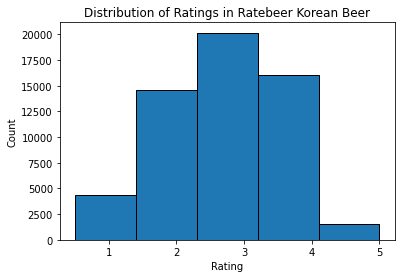

In [18]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Korean Beer')
plt.show()

### Label Encoding

In [19]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [20]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.8
        self.val_size = 0.1
        self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
        n_test = int(self.num_users * self.test_size)
        
        random.seed(42)
        
        val_indices = set(random.choices(range(self.num_users), k=n_val))
        test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices - test_indices
    
        # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
                        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
        else:
            self.df = self.df[self.df['user_id_idx'].isin(test_indices)]

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [21]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [22]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()
        
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [23]:
def validation(model, valid_iter, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)            

            loss_sum += loss.item()

    loss_avg = loss_sum / len(valid_iter)

    return loss_avg

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [25]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
model = AutoRec(num_hidden, num_items).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 1.0262, test Loss: 0.4565
epoch: 1, train Loss: 0.7571, test Loss: 0.3131
epoch: 2, train Loss: 0.6952, test Loss: 0.2528
epoch: 3, train Loss: 0.6431, test Loss: 0.2047
epoch: 4, train Loss: 0.5958, test Loss: 0.1620
epoch: 5, train Loss: 0.5531, test Loss: 0.1339
epoch: 6, train Loss: 0.5161, test Loss: 0.1111
epoch: 7, train Loss: 0.4788, test Loss: 0.0956
epoch: 8, train Loss: 0.4450, test Loss: 0.0821
epoch: 9, train Loss: 0.4148, test Loss: 0.0687
epoch: 10, train Loss: 0.3857, test Loss: 0.0628
epoch: 11, train Loss: 0.3601, test Loss: 0.0540
epoch: 12, train Loss: 0.3352, test Loss: 0.0485
epoch: 13, train Loss: 0.3139, test Loss: 0.0432
epoch: 14, train Loss: 0.2927, test Loss: 0.0394
epoch: 15, train Loss: 0.2736, test Loss: 0.0353
epoch: 16, train Loss: 0.2565, test Loss: 0.0323
epoch: 17, train Loss: 0.2407, test Loss: 0.0296
epoch: 18, train Loss: 0.2250, test Loss: 0.0268
epoch: 19, train Loss: 0.2127, test Loss: 0.0245
epoch: 20, train Loss: 0.2007,

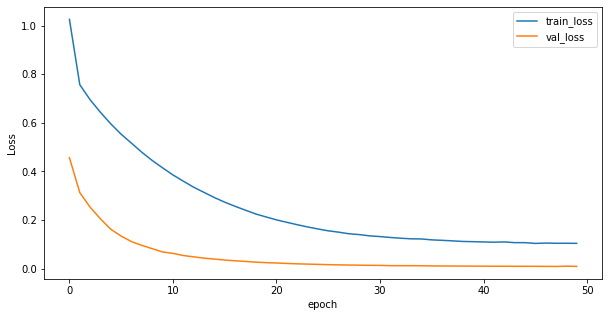

In [27]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
PATH = 'autorec_crawling.pt'
torch.save(model.state_dict(), PATH)

## inference

### 모델 불러오기

In [105]:
PATH = 'autorec_crawling.pt'
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 평가지표 함수

In [106]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [107]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [30]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

### inference 수행

In [31]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.07389477530142492, ndcg@4 = 0.07809682584973217


In [32]:
# test 데이터 user 목록
test_dataset.df.user_id_idx.unique()

array([2379,   78,  870, 1140,   15, 2603, 2466, 1747, 1680,   26, 1043,
       1654,   73,  403,   51,   69,  756,    5,  174,  856, 1902, 2540,
       2471,  414,  299,  699, 2417,  903,  530,  763,   65, 1149, 2635,
        734, 2414, 1835, 1136,  190, 1846,   74, 1863,  542,  225, 2233,
       2451, 2594, 1194,  576, 1784,  526, 2080, 1047,  350, 1588,  866,
       2151, 1215, 2092,  347, 2342, 2312,  852, 1299, 2538,  420, 2056,
        294, 2104,  298, 2317, 1181,  965,  692, 2134,  316,    2, 2172,
       1942,  716, 1151, 1303,  727, 1788, 2054,  605,  459, 1152,  754,
       2016, 2409,  774, 1663,  929, 1906,  318,  201,  541, 2045,  738,
        832, 1936, 2268, 1908, 1994, 1970, 2337,  207, 1340,  676, 1917,
        619,  640, 1119, 1745,  768,  255, 2359,  917, 1499, 2699,  795,
        833,   14, 2097, 1657, 2028, 1121, 1116,  379,  818,  678,  372,
       1283, 1800, 1268, 1859, 2107, 1478,  212, 2435,  791, 2174, 1687,
       1197, 2235,  563, 2649, 2525, 2565, 1400, 20

In [27]:
# 모델 예측 선호 맥주 top4
pred_list[2379]

array([23,  6,  9, 18])

In [28]:
# 유저 실제 선호 맥주 top4
answer_list[2379]

array([23,  6, 18, 58])

In [29]:
test_matrix[2379]

array([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

### 웹사이트 inference

In [113]:
x_test = torch.tensor([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]).to(device)

In [114]:
x_test.type

<function Tensor.type>

In [33]:
# 웹사이트 input
x_test = torch.tensor([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]).to(device)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

# batch_user_index = user_ids.cpu().numpy()
answers = x_test.cpu().numpy().argsort()[-topk:][::-1]

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
    # rating_pred[x_test.cpu().numpy() > 0] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)


[23  6 19  9]
[4.06548   3.9911258 3.612044  3.5583072]


In [31]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([23,  6,  9, 18])

In [32]:
# 유저 실제 선호 맥주 top4
answers

array([23,  6, 18, 58])

In [33]:
# 모델 예측 rating 점수
rating_pred

array([ 2.06483245e+00,  1.46756709e-01,  4.62156415e-01,  2.48338175e+00,
        2.64497232e+00, -2.66054899e-01,  4.00837326e+00,  9.79382575e-01,
        1.86944151e+00,  3.67111540e+00,  1.76397216e+00,  2.22590804e+00,
        1.50869250e+00,  2.26526022e+00, -1.24154218e-01,  2.44071937e+00,
        2.52452183e+00,  1.74720216e+00,  3.36888099e+00,  2.82193184e+00,
        2.96694779e+00,  2.62298012e+00,  1.80712804e-01,  4.54097033e+00,
        3.26054549e+00,  2.77151632e+00,  2.57823062e+00,  3.25641489e+00,
        9.34664086e-02,  2.56362319e+00,  2.85664916e-01,  1.71550417e+00,
       -6.89468086e-02,  9.66699049e-02,  1.59380555e+00,  1.66968358e+00,
        1.06257923e-01, -4.91718873e-02,  3.88721257e-01,  1.40441000e+00,
        1.30208790e-01,  3.69116902e-01,  5.57060957e-01,  2.85109505e-02,
        3.10324168e+00,  2.00185752e+00,  2.20131606e-01,  1.19963385e-01,
        5.77800944e-02, -3.67370881e-02,  8.25221062e-01,  2.80208015e+00,
       -2.13009678e-03, -

In [34]:
# image url
data[data['item_id_idx'].isin(topk_pred_list)]['imageUrl'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_647',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_399',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_814',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_2228'],
      dtype=object)

In [35]:
# 맥주 이름
data[data['item_id_idx'].isin(topk_pred_list)]['item'].unique()

array([ 647,  399,  814, 2228])

### 평가지표 점수

In [36]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [37]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.75

In [38]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.20120249375098728

In [34]:
data

,item,user,rating,imageUrl,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,544,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,538,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,1471,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,378,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,850,56
...,...,...,...,...,...,...
94311,703,sleepdirt,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,2513,10
94312,703,mike mcneil,1.9,https://res.cloudinary.com/ratebeer/image/uplo...,2208,10
94313,703,Sammys,2.8,https://res.cloudinary.com/ratebeer/image/uplo...,1111,10
94316,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,205,10


In [49]:
data_drop = data[['item','item_id_idx']].drop_duplicates()

In [56]:
data_drop.to_csv("mapping_Beer.csv", index=0)

In [52]:
data_drop['item'].value_counts()

75661     1
614833    1
452525    1
7580      1
621308    1
         ..
506847    1
34662     1
64253     1
493355    1
703       1
Name: item, Length: 80, dtype: int64

In [40]:
data['item'].values

array([75661, 75661, 75661, ...,   703,   703,   703])

In [42]:
data['item_id_idx'].values

array([56, 56, 56, ..., 10, 10, 10])

In [41]:
dict(data['item'].values , data['item_id_idx'].values)

TypeError: dict expected at most 1 argument, got 2

In [42]:
data.to_csv('./data/ratebeer_label_encoding.csv', index = False)

In [76]:
in_beer = {
"37":5,
"729":5,
"252000":5,
"64518":5,
"71469":5
}

In [149]:
in_beer.keys()

dict_keys(['37', '729', '252000', '64518', '71469'])

In [150]:
in_beer.values()

dict_values([5, 5, 5, 5, 5])

In [158]:
ratebeer

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
0,1.3,2021-02-27 12:53:53.373,Small can from Valencia. Thanks Mario for this...,2.0,1.0,1.0,3.0,6.0,Grzesiek79,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
1,2.7,2021-01-08 18:06:32.240,"Ar: slod, niska intensywnosc, sladowy slod. Wy...",4.0,5.0,3.0,5.0,10.0,GriZZZly,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
2,3.3,2020-12-17 14:20:21.580,More full bodied than most no doubt. Not reall...,NaN,NaN,NaN,NaN,NaN,bdleedahl,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
3,2.6,2019-11-04 21:37:39.537,330 ml can. Clear pale yellow color with minim...,3.0,5.0,3.0,5.0,10.0,DoctorHU,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
4,2.5,2019-10-05 21:49:19.413,The beer has got a deep golden color with a st...,2.0,4.0,3.0,5.0,11.0,McTapps,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94316,3.0,2000-06-14 04:58:02.000,"pale clear golden colour with a fine head, low...",4.0,5.0,3.0,6.0,12.0,Bov,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94317,4.2,2000-06-10 16:51:58.000,"love that skunky smell ! Actually, my fav eve...",4.0,9.0,4.0,8.0,17.0,sallyclub99,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94318,2.7,2000-06-05 08:46:21.000,Much better than American pilsners which isn't...,2.0,5.0,2.0,6.0,12.0,kublai3,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94319,3.3,2000-06-03 23:59:02.000,"A decent, light-German beer. Not bad, but then...",3.0,6.0,3.0,6.0,15.0,Aubrey,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [78]:
beer_list = pd.read_csv('mapping_Beer.csv')
beer_con = [0 for i in range(beer_list.shape[0])]

In [159]:
ratebeer.columns

Index(['reviewScore', 'reviewTime', 'reviewText', 'appearance', 'aroma',
       'palate', 'taste', 'overall', 'profileName', 'beerName', 'beerID',
       'brewerID', 'ABV', 'style', 'imageUrl'],
      dtype='object')

In [ ]:
pd.merge(beer_list, ratebeer, how='left' on='beerID')

In [161]:
beer_list.rename(columns= {"item" : "beerID"} , inplace=True)

In [168]:
merge_beer = pd.merge(beer_list, ratebeer, how='left' , on='beerID')

In [173]:
merge_beer[['beerID','item_id_idx','beerName']].drop_duplicates().to_csv('../data/ratebeer_label_encoding.csv', index = False)

In [174]:
beer_list = pd.read_csv('../data/ratebeer_label_encoding.csv')

In [180]:
np.random.choice(beer_list['beerName'].values, 10)

array(['Warsteiner Premium Verum', 'Stephans Bräu Hefe-Weizen Naturtrüb',
       'BrewDog Punk IPA', 'Tsingtao Draft Beer 11º (Pure Draft Beer)',
       'Egger Grapefruit Radler', "Beck's", 'Kozel Černý (Dark) 10°',
       'Edelweiss Weissbier Snowfresh', 'Corona Extra',
       'Holsten Premium Bier'], dtype=object)

In [184]:
int(beer_list[beer_list['beerName'] == "Warsteiner Premium Verum"]['beerID'].values)

1417

In [176]:
for key, value in in_beer.items():
    encoding_key = int(beer_list[beer_list['beerID']==int(key)]['item_id_idx'].values)
    beer_con[encoding_key] = float(value)
beer_con

[5.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.0,
 0,
 5.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [116]:
x_test = torch.tensor(x_test).to(device)

In [117]:
x_test

tensor([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 5., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [120]:
# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
model.eval()
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

# batch_user_index = user_ids.cpu().numpy()
answers = x_test.cpu().numpy().argsort()[-topk:][::-1]

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
    # rating_pred[x_test.cpu().numpy() > 0] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[15 52  0 19]
[4.333579  4.0789204 3.7124016 1.8110985]


In [124]:
topk_pred_list.tolist()

[15, 52, 0, 19]

In [136]:
topk_pred_list_item = []
for idx in topk_pred_list:
    item = beer_list[beer_list['item_id_idx']==idx]['item'].values
    topk_pred_list_item.extend(item)

topk_pred_list_item

[729, 71469, 37, 1088]

In [128]:
beer_list

,item,item_id_idx
0,75661,56
1,614833,76
2,169964,63
3,251,3
4,10726,40
...,...,...
75,742,17
76,473,8
77,135361,58
78,2228,23


In [143]:
ratebeer[ratebeer['beerID']==614833]

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
154,2.5,2021-07-21 03:59:49.707,잔에 거칠게 부어보면 인조 탄산기포가 화려하게 쌓이는데 이건 마치 스파클링와인의 대...,1.0,5.0,2.0,5.0,12.0,After.dawn,Apple Fox,614833,2937,4.5,Apple Cider,https://res.cloudinary.com/ratebeer/image/uplo...
155,2.4,2019-04-28 07:17:17.783,Golden color with very thin head. Aroma of swe...,3.0,5.0,3.0,5.0,8.0,AllGrainRater31,Apple Fox,614833,2937,4.5,Apple Cider,https://res.cloudinary.com/ratebeer/image/uplo...
156,2.1,2019-04-09 09:21:07.260,A golden cider with a thin white head. In arom...,3.0,5.0,2.0,4.0,7.0,Lubiere,Apple Fox,614833,2937,4.5,Apple Cider,https://res.cloudinary.com/ratebeer/image/uplo...
157,2.9,2018-05-03 12:13:07.510,Can shared with deanso. Poured a crystal clear...,3.0,5.0,3.0,6.0,12.0,jmgreenuk,Apple Fox,614833,2937,4.5,Apple Cider,https://res.cloudinary.com/ratebeer/image/uplo...
158,2.6,2018-05-03 12:00:47.970,33cl can shared with Jmgreenuk.\r\nVery thin w...,4.0,5.0,3.0,5.0,9.0,deanso,Apple Fox,614833,2937,4.5,Apple Cider,https://res.cloudinary.com/ratebeer/image/uplo...


In [142]:
beer_list[beer_list['item']==48076]

,item,item_id_idx
